## Mount Google Drive 
- Development Environment : Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir data
!mkdir weight

In [ ]:
!ls

data  faces.tar.gz  images  LICENCE  README.md	source	vgg16.ipynb  weight


In [ ]:
%cd weight

/content/drive/MyDrive/2023/dev/vgg-age/weight


In [ ]:
%cd /content/drive/MyDrive/2023/dev/vgg-age

/content/drive/MyDrive/2023/vgg-age


### Download the Dataset 
- From the link below using the wget command

In [ ]:
!wget --user=adiencedb --password=adience http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/faces.tar.gz

--2023-02-15 10:37:51--  http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/faces.tar.gz
Resolving www.cslab.openu.ac.il (www.cslab.openu.ac.il)... 192.114.0.68
Connecting to www.cslab.openu.ac.il (www.cslab.openu.ac.il)|192.114.0.68|:80... connected.
HTTP request sent, awaiting response... 401 Unauthorized
Authentication selected: Basic realm="Restricted Content"
Reusing existing connection to www.cslab.openu.ac.il:80.
HTTP request sent, awaiting response... 200 OK
Length: 1294832900 (1.2G) [application/x-gzip]
Saving to: ‘faces.tar.gz’

faces.tar.gz        100%[===================>]   1.21G  17.7MB/s    in 71s     

2023-02-15 10:39:04 (17.3 MB/s) - ‘faces.tar.gz’ saved [1294832900/1294832900]



In [ ]:
! tar -xf /content/drive/MyDrive/2023/dev/vgg-age/faces.tar.gz -C data/

## Load data from drive

Adience Dataset is used for training <br>
https://talhassner.github.io/home/projects/Adience/Adience-data.html

The dataset can be downloaded using wget with authentication.

## Reading CSV

The text files named fold_0_data.txt thru fold_5_data.txt have mapping of filenames to resprective age and gender of the person in image. Since we only predict age, we ignore gender and other classes

In [ ]:
import pandas as pd

In [ ]:
frames = []
folder_path = "/content/drive/MyDrive/2023/dev/vgg-age/images/"

for i in range(5):
    temp_df = pd.read_csv(folder_path + "fold_" + str(i) + "_data.txt", delimiter="\t")
    frames.append(temp_df)

df = pd.concat(frames)

In [ ]:
df.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


In [ ]:
"""
FINAL CLASSES
(00, 02)
(04, 06)
(08, 12)
(15, 20)
(25, 32)
(38, 43)
(48, 53)
(60, 100)
None
"""

map_dict = {
    "13": "(08, 12)",
    "2" : "(00, 02)",
    "22": "(15, 20)",
    "23": "(25, 32)",
    "29": "(25, 32)",
    "3" : "(00, 02)",
    "32": "(25, 32)",
    "34": "(25, 32)",
    "35": "(25, 32)",
    "36": "(38, 43)",
    "42": "(38, 43)",
    "45": "(38, 43)",
    "46": "(48, 53)",
    "55": "(48, 53)",
    "56": "(48, 53)",
    "57": "(60, 100)",
    "58": "(60, 100)",
    "(8, 23)" : "(08, 12)",
    "(27, 32)": "(25, 32)",
    "(38, 42)": "(38, 43)",
    "(38, 48)": "(38, 43)",
    "(00, 02)" : "(00, 02)",
    "(04, 06)" : "(04, 06)",
    "(08, 12)" : "(08, 12)",
    "(15, 20)" : "(15, 20)",
    "(25, 32)" : "(25, 32)",
    "(38, 43)" : "(38, 43)",
    "(48, 53)" : "(48, 53)",
    "(60, 100)": "(60, 100)"
}

def map_age(x):
    return map_dict.get(x, x)

df["age"] = df["age"].map(map_age)

In [ ]:
df["age"].value_counts()

(25, 32)     5589
(38, 43)     2490
(0, 2)       2488
(4, 6)       2140
(8, 12)      2124
(15, 20)     1791
(48, 53)      909
(60, 100)     901
None          748
(08, 12)      169
(00, 02)       21
Name: age, dtype: int64

## Restructuring Directory

The directory structure is not recognizable for pytorch dataloaders. <br>
To restructure the tree so that it is readable, every file is moved under the subfolder named after its class.

In [ ]:
import os
import shutil

In [ ]:
folder_path =  "/content/drive/MyDrive/2023/dev/vgg-age/data/faces"

In [ ]:
file_list = []
formats = ["jpg", "png"]

for subdir in os.listdir(folder_path):
    subpath = os.path.join(folder_path, subdir)
    if os.path.isdir(subpath):
        for f in os.listdir(subpath):
            filepath = os.path.join(subpath, f)
            part = f.split(".")
            if os.path.isfile(filepath) and part[-1] in formats:
                file_list.append((filepath, f))

print(len(file_list))

19370


In [ ]:
# DONT INTERRUPT WHILE RUNNING
# SHOWS PROGRESS

im_len = len(file_list)

for i, (filepath, filename) in enumerate(file_list):

    # get the identifiers
    parts = filename.split(".")
    user_id = filepath.split("/")[-2]
    file_id = parts[-2] + "." + parts[-1]
    face_id = int(parts[-3])

    # find class
    class_ = df[
       (df["user_id"] == user_id) & 
       (df["original_image"] == file_id) & 
       (df["face_id"] == face_id)
    ]["age"].values[0]

    new_path = os.path.join(folder_path, class_)
    
    if not os.path.exists(new_path):
        os.makedirs(new_path)

    # move file
    new_path = os.path.join(new_path, filename)
    shutil.move(filepath, new_path)
    
    # progress
    prog = (20 * (i + 1)) // im_len
    print("\r[" + "="*prog + "_"*(20-prog) + "]", end="")

[====================]

In [ ]:
# delete unwanted files or empty folders
folder_path = "/content/drive/MyDrive/2023/dev/vgg-age/data/faces"

for subdir in os.listdir(folder_path):
    subpath = os.path.join(folder_path, subdir)

    if os.path.isdir(subpath):
        if subdir[0] != "(":
            shutil.rmtree(subpath)
    elif os.path.isfile(subpath):
        os.remove(subdir)

In [ ]:
# list the classes
! ls /content/drive/MyDrive/2023/dev/vgg-age/data/faces

'(00, 02)'  '(08, 12)'	'(25, 32)'  '(4, 6)'	'(60, 100)'
'(0, 2)'    '(15, 20)'	'(38, 43)'  '(48, 53)'	'(8, 12)'


In [ ]:
!ls

data  faces.tar.gz  images  LICENCE  README.md	source	vgg16.ipynb  weight


In [ ]:
# # compress and save to drive for future purposes
# ! tar -czvf faces-cleaned.tar.gz data/faces
# ! cp faces.tar.gz /content/drive/MyDrive/2023/vgg-age/data

## Label correction

Turns out the classes sorting is messed up because of 1st digit sorting. <br>
This creates problems for manual prediction checking, and neatness. <br>
This can be corrected by adding an extra zero in the beginning.

In [ ]:
%cd /content/drive/MyDrive/2023/dev/vgg-age

/content/drive/MyDrive/2023/dev/vgg-age


In [ ]:
! mkdir -p 'data/faces/(00, 02)'
! mkdir -p 'data/faces/(04, 06)'
! mkdir -p 'data/faces/(08, 12)'

In [ ]:
! mv 'data/faces/(0, 2)'/* 'data/faces/(00, 02)'
! mv 'data/faces/(4, 6)'/* 'data/faces/(04, 06)'
! mv 'data/faces/(8, 12)'/* 'data/faces/(08, 12)'

In [ ]:
! rm -rf 'data/faces/(0, 2)'
! rm -rf 'data/faces/(4, 6)'
! rm -rf 'data/faces/(8, 12)'

In [ ]:
! ls data/faces/

'(00, 02)'  '(08, 12)'	'(25, 32)'  '(48, 53)'
'(04, 06)'  '(15, 20)'	'(38, 43)'  '(60, 100)'


## Preparation

In [ ]:
import torch
import source.models as models
import source.worker as worker
import source.loader as loader

In [ ]:
# the mean and std of dataset are found by running this
# takes some time to iterate twice
loader.find_mean_std("/content/drive/MyDrive/2023/dev/vgg-age/data/faces")

(tensor([0.4378, 0.3396, 0.3038]), tensor([0.2860, 0.2525, 0.2357]))

In [ ]:
# loader.mean and loader.std set the mean and standard deviation of the color channels of the images respectively. 
loader.random_scale = (0.8, 1.0)
loader.mean = [0.438, 0.340, 0.304]
loader.std  = [0.286, 0.253, 0.236]

In [ ]:
# Dataset Loader to feed into network
# 20% of data is used for validation
loaders = loader.split_loader("/content/drive/MyDrive/2023/dev/vgg-age/data/faces", valid_frac=0.2, batch_size=32)

In [ ]:
# pretrained weights - for convolution layers
state = loader.load_pth("/content/drive/MyDrive/2023/VGG/vgg-age/weight/vgg_face_dag.pth")

## Model initialization

In [ ]:
model = models.vgg16(num_classes=8)

In [ ]:
# pretrained vgg-face
model.load_weights(state)

   features.0.weight         Loaded
   features.0.bias           Loaded
   features.2.weight         Loaded
   features.2.bias           Loaded
   features.5.weight         Loaded
   features.5.bias           Loaded
   features.7.weight         Loaded
   features.7.bias           Loaded
   features.10.weight        Loaded
   features.10.bias          Loaded
   features.12.weight        Loaded
   features.12.bias          Loaded
   features.14.weight        Loaded
   features.14.bias          Loaded
   features.17.weight        Loaded
   features.17.bias          Loaded
   features.19.weight        Loaded
   features.19.bias          Loaded
   features.21.weight        Loaded
   features.21.bias          Loaded
   features.24.weight        Loaded
   features.24.bias          Loaded
   features.26.weight        Loaded
   features.26.bias          Loaded
   features.28.weight        Loaded
   features.28.bias          Loaded
   classifier.0.weight       Ignored
   classifier.0.bias       

In [ ]:
# gives parameter count and memory in MB
model.memory_usage()

Conv   : 14714688
FC     : 13112328
-----------------
Total  : 27827016
Memory : 106.15MB



In [ ]:
# train for one epoch
worker.train(model, loaders, lr=0.01, epochs=3)

=> training vgg16
=> no cuda devices found, using cpu for training
=> checkpoints will be saved as checkpoint.pth
=> training started at Feb-15 10:48:05

EPOCH : 0
(466/466)[====================]       Loss: 1.2575 (1.2754)        Acc@1: 44.444 (51.181)       Acc@5: 100.000 (95.812)
VALIDATION :
(117/117)[====================]       Loss: 1.0679 (1.0638)        Acc@1: 50.000 (58.110)       Acc@5: 100.000 (99.006)

EPOCH : 1
(466/466)[====================]       Loss: 1.1830 (0.9337)        Acc@1: 50.000 (63.384)       Acc@5: 100.000 (99.168)
VALIDATION :
(117/117)[====================]       Loss: 0.8509 (0.9186)        Acc@1: 66.667 (63.963)       Acc@5: 100.000 (98.738)

EPOCH : 2
(466/466)[====================]       Loss: 0.8923 (0.8039)        Acc@1: 66.667 (68.398)       Acc@5: 100.000 (99.436)
VALIDATION :
(117/117)[====================]       Loss: 1.2410 (0.7758)        Acc@1: 41.667 (70.381)       Acc@5: 100.000 (99.275)


In [ ]:
pwd

'/content/drive/MyDrive/2023/dev/vgg-age'

In [ ]:
# save checkpoint to drive
! cp checkpoint.pth /content/drive/MyDrive/2023/dev/vgg-age/checkpoint.pth

cp: 'checkpoint.pth' and '/content/drive/MyDrive/2023/dev/vgg-age/checkpoint.pth' are the same file


## Confusion Matrix

In [ ]:
# to try out saved version

check = loader.load_pth("checkpoint.pth")
model.load_weights(check["state_dict"])

   features.0.weight         Loaded
   features.0.bias           Loaded
   features.2.weight         Loaded
   features.2.bias           Loaded
   features.5.weight         Loaded
   features.5.bias           Loaded
   features.7.weight         Loaded
   features.7.bias           Loaded
   features.10.weight        Loaded
   features.10.bias          Loaded
   features.12.weight        Loaded
   features.12.bias          Loaded
   features.14.weight        Loaded
   features.14.bias          Loaded
   features.17.weight        Loaded
   features.17.bias          Loaded
   features.19.weight        Loaded
   features.19.bias          Loaded
   features.21.weight        Loaded
   features.21.bias          Loaded
   features.24.weight        Loaded
   features.24.bias          Loaded
   features.26.weight        Loaded
   features.26.bias          Loaded
   features.28.weight        Loaded
   features.28.bias          Loaded
   classifier.0.weight       Loaded
   classifier.0.bias        

In [ ]:
valid_loader = loaders[1]
conf_mat = worker.confusion_matrix(model, valid_loader)

VALIDATION :
(117/117)[====================]


In [ ]:
for row in conf_mat:
    for elem in row:
        print("%.2f"%(elem*100), end="\t")
    print("")

87.97	11.00	0.00	0.62	0.41	0.00	0.00	0.00	
5.41	89.41	3.06	1.18	0.94	0.00	0.00	0.00	
0.21	15.24	75.99	5.43	2.30	0.84	0.00	0.00	
0.00	1.71	10.54	48.43	37.61	1.71	0.00	0.00	
0.00	0.98	3.03	4.55	84.67	6.51	0.27	0.00	
0.00	0.21	1.85	1.23	44.03	47.33	4.53	0.82	
0.00	1.12	0.00	2.25	14.61	49.44	25.28	7.30	
0.00	0.50	1.49	0.50	6.97	25.37	36.32	28.86	


In [ ]:
# one-off accuracy
ncls = len(conf_mat)
tot_acc = 0

for i in range(ncls):
    
    acc = conf_mat[i][i]

    # add left
    if i > 0:
        acc += conf_mat[i][i-1]
    
    if i < ncls - 1:
        acc += conf_mat[i][i+1]
    
    tot_acc += acc

tot_acc = tot_acc / ncls
print("%.2f" % (tot_acc * 100))

91.11


## Visualization

The corresponding predictions and target labels are visualized along with the input images.

In [ ]:
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [ ]:
# get index to class mapping
dire = "data/faces"
classes = os.listdir(dire)
classes.sort()
idx_to_class = {i:classes[i] for i in range(len(classes))}
print(idx_to_class)

{0: '(00, 02)', 1: '(04, 06)', 2: '(08, 12)', 3: '(15, 20)', 4: '(25, 32)', 5: '(38, 43)', 6: '(48, 53)', 7: '(60, 100)'}


In [ ]:
# turn model to evaluation and move to cpu
model.eval()
batch_size = 32
model.to(torch.device("cpu"))

vgg16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [ ]:
# inverse transform to show images
mean = loader.mean
std  = loader.std
mn_inv = [-m/s for m, s in zip(mean, std)]
sd_inv = [1/s for s in std]
inv_transform = transforms.Normalize(mean=mn_inv, std=sd_inv)

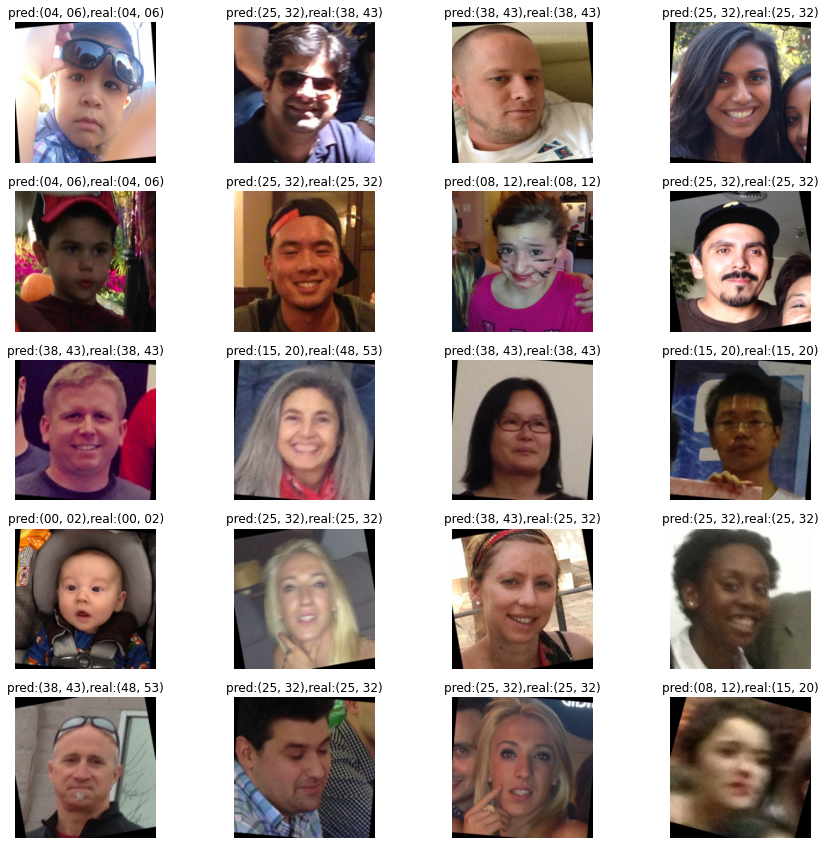

In [ ]:
with torch.no_grad():
    for i, (input, target) in enumerate(valid_loader):

        output = model(input)
        _, preds = torch.max(output, 1)

        fig=plt.figure(figsize=(15, 15))
        columns = 4
        rows = 5

        for i in range(1, columns*rows + 1):

            pred_class = idx_to_class[int(preds[i])]
            real_class = idx_to_class[int(target[i])]

            ax = fig.add_subplot(rows, columns, i)
            ax.title.set_text("pred:" + pred_class + "," + "real:" + real_class)
            ax.axis("off")

            plt.imshow(inv_transform(input[i]).permute(1, 2, 0))

        break

plt.show()

## For cleaning gpu cache and reloading

In [ ]:
del loaders
del model
del state
torch.cuda.empty_cache()

In [ ]:
import importlib
importlib.reload(models)
importlib.reload(worker)
importlib.reload(loader)